# Fitting a 3 variable based non-linear equation using a 3 layered neural network:

## Equation:
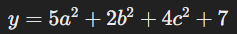

## Generating the Data

In [ ]:
import numpy as np
import pandas as pd

np.random.seed(7)

a_values = np.random.uniform(-10, 10, 500)
b_values = np.random.uniform(-10, 10, 500)
c_values = np.random.uniform(-10, 10, 500)
y_values = 5*a_values**2 + 2*b_values**2 + 4*c_values**2 + 7

df = pd.DataFrame({'a': a_values, 'b': b_values, 'c': c_values, 'y': y_values})

x = df.drop('y', axis=1).to_numpy()
y = df['y'].to_numpy().reshape(-1, 1)

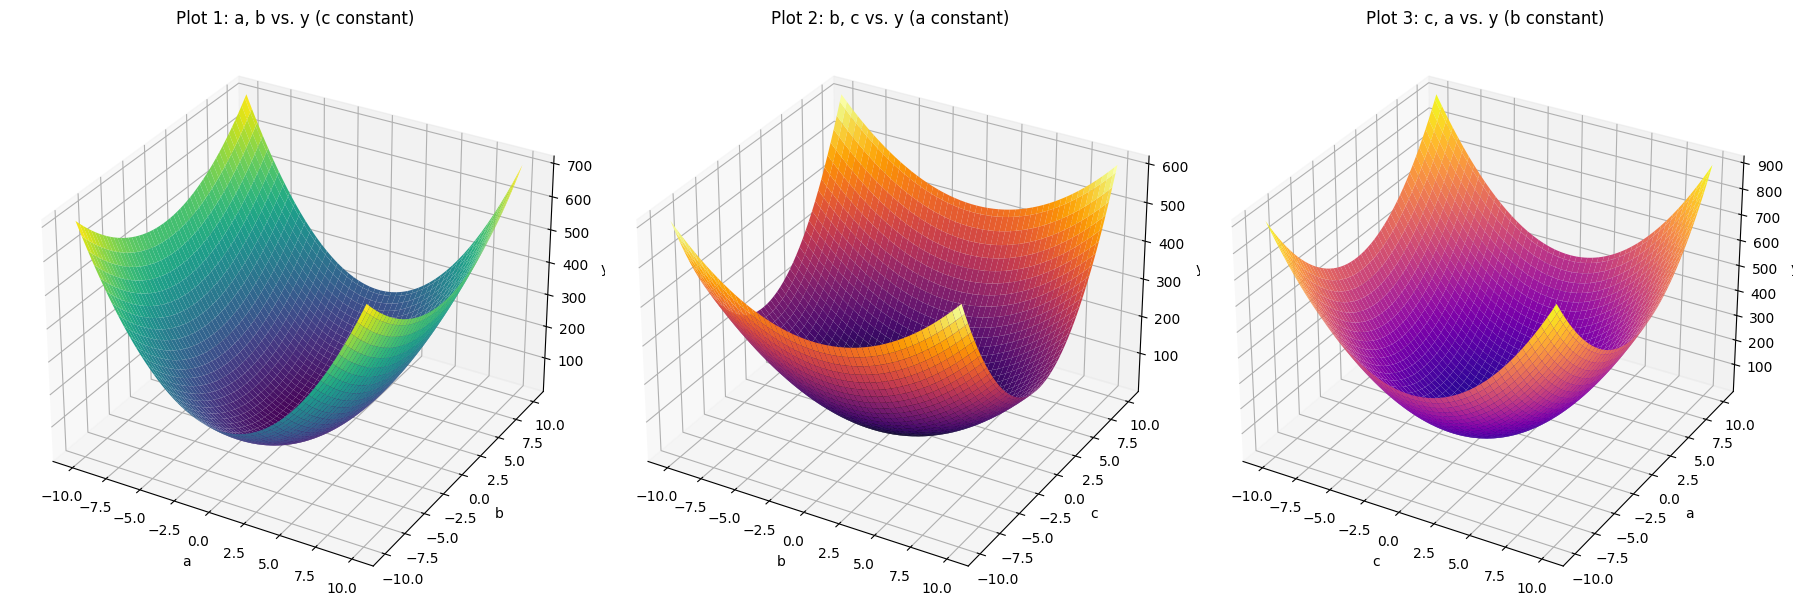

In [ ]:
# plotting 2 variables across the output variable with keeping the 3rd variable constant (median value)

# Generate a grid of values for 'a', 'b', and 'c' based on the base equation
# and plot them accordingly, keeping one variable constant in each plot.

a_grid, b_grid = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
x_a, x_b, x_c = x[:, 0], x[:, 1], x[:, 2]
a_median, b_median, c_median = np.median(x_a), np.median(x_b), np.median(x_c)


# Keeping 'c' constant at its median value for the first plot
c_constant = c_median
y_grid1 = 5*a_grid**2 + 2*b_grid**2 + 4*c_constant**2 + 7

fig = plt.figure(figsize=(18, 6))

# Plot 1: 'a', 'b' vs 'y' with 'c' constant
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(a_grid, b_grid, y_grid1, cmap='viridis')
ax1.set_xlabel('a')
ax1.set_ylabel('b')
ax1.set_zlabel('y')
ax1.set_title('Plot 1: a, b vs. y (c constant)')

a_median = np.median(x_a)
# Keeping 'a' constant at its median value for the second plot
a_constant = a_median
y_grid2 = 5*a_constant**2 + 2*b_grid**2 + 4*a_grid**2 + 7  # Using 'a_grid' as 'c' for variation

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(b_grid, a_grid, y_grid2, cmap='inferno')  # Swapping 'b' and 'c' roles
ax2.set_xlabel('b')
ax2.set_ylabel('c')
ax2.set_zlabel('y')
ax2.set_title('Plot 2: b, c vs. y (a constant)')

# Keeping 'b' constant at its median value for the third plot
b_constant = b_median
y_grid3 = 5*a_grid**2 + 2*b_constant**2 + 4*b_grid**2 + 7  # Using 'b_grid' as 'c' for variation

ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(a_grid, b_grid, y_grid3, cmap='plasma')  # Swapping 'b' and 'c' roles again
ax3.set_xlabel('c')
ax3.set_ylabel('a')
ax3.set_zlabel('y')
ax3.set_title('Plot 3: c, a vs. y (b constant)')

plt.tight_layout()
plt.show()

## Einsum:

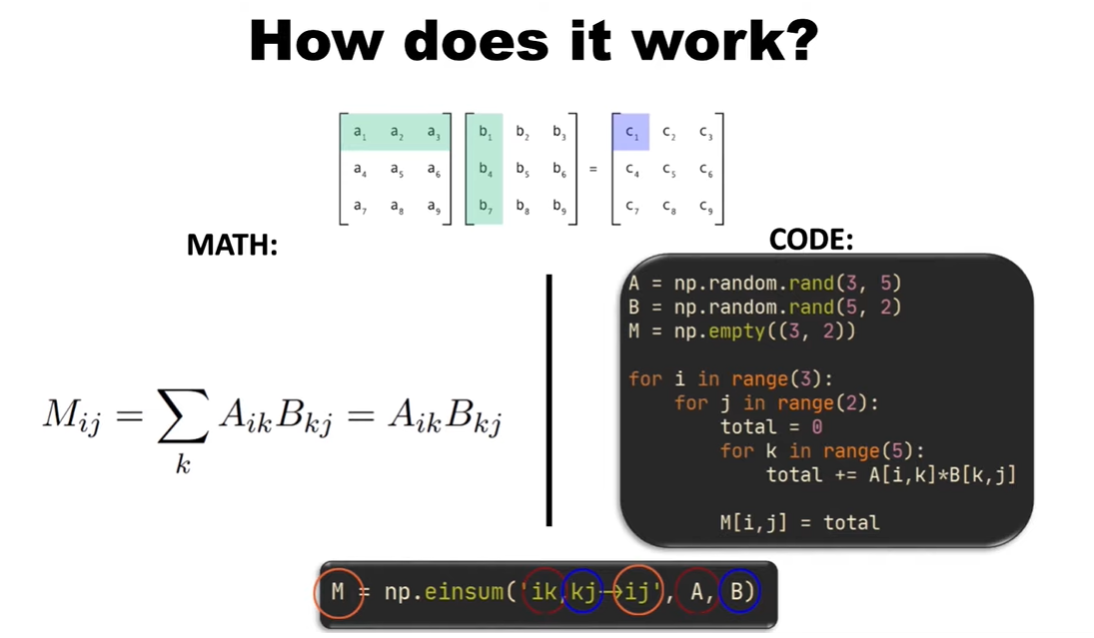

In [ ]:
# To Understand Einsum: https://youtu.be/pkVwUVEHmfI?si=VATEhN4gwJXOrZ5i

import tensorflow as tf

#Linear Layer
class Linear:
    def __init__(self, input_dim: int, num_hidden: int):
        self.weights = tf.Variable(np.random.randn(input_dim, num_hidden).astype(np.float32) * np.sqrt(2. / input_dim))
        self.bias = tf.Variable(np.zeros((1, num_hidden), dtype=np.float32))
        # self.weights = np.random.randn(input_dim, num_hidden) * np.sqrt(2. / input_dim)
        # self.bias = np.zeros((1, num_hidden))

    def __call__(self, x):
        self.x = x
        #return x @ self.weights + self.bias
        return tf.einsum('ij,jk->ik', x, self.weights) + self.bias

    def backward(self, gradient):
        #self.weights_gradient = self.x.T @ gradient / self.x.shape[0]
        self.weights_gradient = tf.einsum('ij,ik->jk', self.x, gradient) / self.x.shape[0]
        self.bias_gradient = np.mean(gradient, axis=0, keepdims=True)
        #return  gradient @ self.weights.T
        return tf.einsum('ij,kj->ik', gradient, self.weights)

    # def update(self, lr):
    #     self.weights -= lr * self.weights_gradient
    #     self.bias -= lr * self.bias_gradient
    def update(self, lr):
        # Use assign_sub for in-place subtraction
        self.weights.assign_sub(lr * self.weights_gradient)
        self.bias.assign_sub(lr * self.bias_gradient)

In [ ]:
#Non-linear Activation Function
class Relu:
    def __call__(self, input_):
        self.input_ = input_
        return tf.maximum(0.0, input_)

    def backward(self, output_gradient):
        #return (self.input_ > 0) * output_gradient
        return tf.cast(self.input_ > 0, dtype=tf.float32) * tf.cast(output_gradient, dtype=tf.float32)

In [ ]:
#Loss Function
class MSE:
    def __call__(self, y_pred, y_true):
        self.y_pred = y_pred
        self.y_true = y_true
        return np.mean((y_pred - y_true) ** 2)

    def backward(self):
        return 2. * (self.y_pred - self.y_true) / self.y_pred.shape[0]

In [ ]:
class Model:
    def __init__(self, input_dim, num_hidden1, num_hidden2):
        self.linear1 = Linear(input_dim, num_hidden1)
        self.relu1 = Relu()
        self.linear2 = Linear(num_hidden1, num_hidden2)
        self.relu2 = Relu()
        self.linear3 = Linear(num_hidden2, 1)

    def __call__(self, x):
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.linear3(x)
        return x

    def backward(self, output_gradient):
        gradient = self.linear3.backward(output_gradient)
        gradient = self.relu2.backward(gradient)
        gradient = self.linear2.backward(gradient)
        gradient = self.relu1.backward(gradient)
        self.linear1.backward(gradient)

    def update(self, lr):
        self.linear1.update(lr)
        self.linear2.update(lr)
        self.linear3.update(lr)

In [ ]:
def fit(x, y, model, loss, lr, num_epochs):
    for epoch in range(num_epochs):
        y_pred = model(x)
        loss_value = loss(y_pred, y)
        gradient_from_loss = loss.backward()
        model.backward(gradient_from_loss)
        model.update(lr)

        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss {loss_value}')

In [ ]:
model = Model(3, 20, 20)
loss = MSE()

# Train the Model
fit(x, y, model, loss, lr=0.01, num_epochs=50000)

Epoch 0, Loss 177930.40625
Epoch 100, Loss 5031.98095703125
Epoch 200, Loss 4539.61376953125
Epoch 300, Loss 4170.728515625
Epoch 400, Loss 3828.534912109375
Epoch 500, Loss 3495.855224609375
Epoch 600, Loss 3156.410400390625
Epoch 700, Loss 2809.560546875
Epoch 800, Loss 2450.424072265625
Epoch 900, Loss 2100.14599609375
Epoch 1000, Loss 1785.4639892578125
Epoch 1100, Loss 1494.3316650390625
Epoch 1200, Loss 1228.8101806640625
Epoch 1300, Loss 1022.9862670898438
Epoch 1400, Loss 863.0593872070312
Epoch 1500, Loss 740.564208984375
Epoch 1600, Loss 663.2353515625
Epoch 1700, Loss 604.81103515625
Epoch 1800, Loss 558.3014526367188
Epoch 1900, Loss 518.036376953125
Epoch 2000, Loss 482.7232666015625
Epoch 2100, Loss 482.9324951171875
Epoch 2200, Loss 511.67156982421875
Epoch 2300, Loss 735.3092651367188
Epoch 2400, Loss 647.8062744140625
Epoch 2500, Loss 613.0180053710938
Epoch 2600, Loss 623.7157592773438
Epoch 2700, Loss 637.6484985351562
Epoch 2800, Loss 606.0796508789062
Epoch 2900, L

In [ ]:
y_pred = model(x)

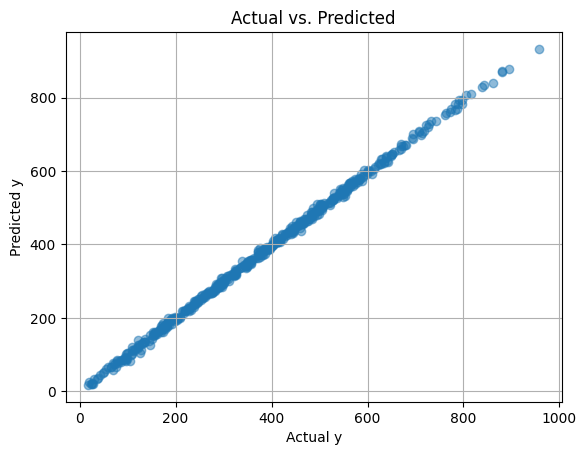

In [ ]:
import matplotlib.pyplot as plt

# Plotting the actual y vs. predictions
plt.scatter(y, y_pred, alpha=0.5)
plt.title('Actual vs. Predicted')
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.grid(True)
plt.show()